In [1]:
import pandas as pd 
import numpy as np
import spacy
import random
import time
import sys
from spacy import displacy
from spacy.util import minibatch, compounding
from itertools import chain
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
def load_data(file_path):
    '''
    input: word \t label \n  word \t label \n
    output: sentence, {entities: [(start, end, label), (start, end, label)]}
    '''
    file = open(file_path, 'r')
    train_data, entities, sentence, unique_labels = [], [], [], []
    current_annotation = None
    start, end = 0 , 0
    for line in file:
        line = line.strip('\n').split('\t')
        if len(line)>1:
            label = line[1]
            if label!='O':
                label = line[1] + '_Disease' # add disease on tag words
                
            word = line[0]
            sentence.append(word)
            start = end
            end += (len(word) + 1)
            
            if label == 'I_Disease':
                entities.append((start, end-1, label)) # add postition
                
            if label == 'B_Disease':
                entities.append((start, end-1, label)) # add postition
            
            if label!= 'O' and label not in unique_labels:
                unique_labels.append(label)
        
        if len(line)==1:
            if len(entities)>0:
                sentence = ' '.join(sentence)
                train_data.append([sentence, {'entities': entities}])
            end, start = 0, 0
            entities, sentence = [], []
        
    file.close()
    return train_data, unique_labels

In [3]:
TRAIN_DATA, UNIQUE_LABELS = load_data('BC5CDR-disease/train.tsv')
TEST_DATA, _ = load_data('BC5CDR-disease/test.tsv')
VALID_DATA,_ = load_data('BC5CDR-disease/train_dev.tsv')

In [4]:
def get_precision(prediction, truth):
    return len([x for x in prediction if x in truth])/(len(prediction)+1e-20)

def get_recall(prediction, truth):
    return len([x for x in truth if x in prediction])/(len(truth)+1e-20)

def get_f1(prediction, truth):
    precision = get_precision(prediction, truth)
    recall = get_precision(prediction, truth)
    return 2 * (precision * recall) / (precision + recall + 1e-20)

In [5]:
def evaluation(ner, data):
    '''
    ner: pipeline
    data: dataset
    '''
    predictions = [ner(x[0]) for x in data]
    precisions, recalls, f1s = [], [], []
    for prediction, truth in zip(predictions, data):
        truth = [x[2] for x in list(chain.from_iterable(truth[1].values()))]
        prediction = [i.label_ for i in prediction.ents]
        precision = get_precision(prediction, truth)
        recall = get_recall(prediction, truth)
        f1 = get_f1(prediction, truth)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    
    return {'avg_precision':np.mean(precisions), 'avg_recall':np.mean(recalls), 'avg_f1':np.mean(f1s)}

In [6]:
def train_spacy_model(train_data, unique_labels, iterations, dropout = 0.5, display_freq = 1):
    valid_f1s = []
    train_f1s = []
    nlp = spacy.load('en_core_web_md')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    else:
        ner = nlp.get_pipe('ner')
    
    for i in unique_labels:
        ner.add_label(i)
        
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe!='ner']
    
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.begin_training()
        for iteration in range(iterations):
            random.shuffle(train_data)
            losses = {}
            batches = minibatch(train_data, size = compounding(16.0, 64.0, 1.5))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(texts, annotations, drop = dropout, sgd = optimizer, losses = losses)
                
            scores = evaluation(nlp, VALID_DATA)
            valid_f1s.append(scores['avg_f1'])
            print('----------------------------------------------------------')
            print('Iteration = '+str(iteration))
            print('Losses = '+str(losses))
            print('---------------------Validation set-----------------------')
            print('F1 = '+str(scores['avg_f1']))
            print('Precision = '+str(scores['avg_precision']))       
            print('Recall = '+str(scores['avg_recall']))
            
            scores = evaluation(nlp, TRAIN_DATA)
            train_f1s.append(scores['avg_f1'])
            print('---------------------Train set-----------------------------')
            print('F1 = '+str(scores['avg_f1']))
            print('Precision = '+str(scores['avg_precision']))       
            print('Recall = '+str(scores['avg_recall']))
            print('----------------------------------------------------------')
    
    return nlp, valid_f1s, train_f1s              

In [7]:
ner, valid_f1s, train_f1s = train_spacy_model(TRAIN_DATA, UNIQUE_LABELS, 20)
ner.to_disk('CustomNER')

----------------------------------------------------------
Iteration = 0
Losses = {'ner': 55235.211071014404}
---------------------Validation set-----------------------
F1 = 0.0
Precision = 0.0
Recall = 0.0
---------------------Train set-----------------------------
F1 = 0.0
Precision = 0.0
Recall = 0.0
----------------------------------------------------------
----------------------------------------------------------
Iteration = 1
Losses = {'ner': 47706.87215423584}
---------------------Validation set-----------------------
F1 = 0.0
Precision = 0.0
Recall = 0.0
---------------------Train set-----------------------------
F1 = 0.0
Precision = 0.0
Recall = 0.0
----------------------------------------------------------
----------------------------------------------------------
Iteration = 2
Losses = {'ner': 46789.27061748505}
---------------------Validation set-----------------------
F1 = 0.0
Precision = 0.0
Recall = 0.0
---------------------Train set-----------------------------
F1 = 0.

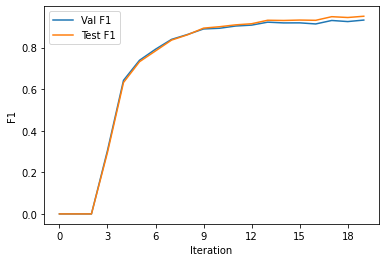

In [8]:
x = range(0, 20)
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(valid_f1s,label='Val F1')
ax.plot(train_f1s,label='Test F1')
ax.set_xlabel('Iteration')
ax.set_ylabel('F1')
ax.legend()


In [9]:
def load_spacy_model(model_path):
    nlp = spacy.blank('en')
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner)
    ner = nlp.from_disk(model_path)
    return ner

In [10]:
ner = load_spacy_model('CustomNER')
test_sentences = [x[0] for x in TEST_DATA[:500]]
for x in test_sentences:
    doc = ner(x)
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    displacy.render(doc, jupyter=True, style='ent')

Torsade 0 7 B_Disease
de 8 10 I_Disease
pointes 11 18 I_Disease
ventricular 19 30 I_Disease
tachycardia 31 42 I_Disease
dilated 111 118 B_Disease
cardiomyopathy 119 133 I_Disease
congestive 138 148 B_Disease
heart 149 154 I_Disease
failure 155 162 I_Disease


heart 79 84 B_Disease
failure 85 92 I_Disease
dilated 106 113 B_Disease
cardiomyopathy 114 128 I_Disease
ventricular 156 167 B_Disease
arrhythmias 168 179 I_Disease
pointes 225 232 B_Disease
ventricular 233 244 I_Disease
tachycardia 245 256 I_Disease


torsade 15 22 B_Disease
de 23 25 I_Disease
pointes 26 33 I_Disease
ventricular 34 45 I_Disease
tachycardia 46 57 I_Disease
arrhythmias 138 149 B_Disease
rhythm 227 233 B_Disease
disturbances 234 246 I_Disease


reaction 98 106 B_Disease
dyspnea 109 116 B_Disease
loss 119 123 B_Disease
consciousness 127 140 B_Disease
rash 171 175 B_Disease
sensation 237 246 B_Disease
pain 268 272 B_Disease


allergy 94 101 B_Disease


hyperammonemic 18 32 B_Disease
encephalopathy 33 47 I_Disease
cancer 51 57 B_Disease
dehydration 145 156 B_Disease
infection 161 170 B_Disease


cancer 23 29 B_Disease
hyperammonemic 72 86 B_Disease
encephalopathy 87 101 I_Disease


decompensated 25 38 B_Disease
liver 39 44 I_Disease
disease 45 52 I_Disease


hyperammonemic 9 23 B_Disease
encephalopathy 24 38 I_Disease


azotemia 59 67 B_Disease
bacterial 98 107 B_Disease
infections 108 118 I_Disease
infection 143 152 B_Disease
dehydration 180 191 B_Disease


hyperammonemia 54 68 B_Disease
bacterial 99 108 B_Disease
infections 109 119 I_Disease


hyperammonemic 16 30 B_Disease
encephalopathy 31 45 I_Disease


Azotemia 0 8 B_Disease
fluid 16 21 B_Disease
insufficiency 22 35 I_Disease
bacterial 40 49 B_Disease
infections 50 60 I_Disease


hypoactivity 138 150 B_Disease
hyperactivity 228 241 B_Disease


hypoactivity 137 149 B_Disease
hyperactivity 177 190 B_Disease


memory 56 62 B_Disease
impairment 63 73 I_Disease


allodynia 122 131 B_Disease
hyperalgesia 136 148 B_Disease


impairment 109 119 B_Disease
memory 136 142 B_Disease


liver 20 25 B_Disease
toxicity 26 34 I_Disease


rheumatoid 44 54 B_Disease
arthritis 55 64 I_Disease
cytolytic 85 94 B_Disease
hepatitis 95 104 I_Disease


cytolytic 10 19 B_Disease
hepatitis 20 29 I_Disease
hypersensitivity 157 173 B_Disease


liver 37 42 B_Disease
toxicity 43 51 I_Disease
hepatic 102 109 B_Disease
damage 110 116 I_Disease


bone 84 88 B_Disease
marrow 89 95 I_Disease
aplastic 160 168 B_Disease
anemia 169 175 I_Disease


aplastic 182 190 B_Disease
anemia 191 197 I_Disease


necrosis 3 11 B_Disease
necrosis 155 163 B_Disease


aplastic 51 59 B_Disease
anemia 60 66 I_Disease
aplastic 242 250 B_Disease
anemia 251 257 I_Disease


catalepsy 31 40 B_Disease
atypical 79 87 B_Disease
antipsychotic 88 101 I_Disease
nature 102 108 I_Disease


catalepsy 84 93 B_Disease


catalepsy 112 121 B_Disease


catalepsy 84 93 B_Disease


catalepsy 99 108 B_Disease


Catalepsy 0 9 B_Disease


catalepsy 110 119 B_Disease


ventricular 15 26 B_Disease
dysfunction 27 38 I_Disease
coronary 63 71 B_Disease
artery 72 78 I_Disease
disease 79 86 I_Disease
myocardial 130 140 B_Disease
ischaemia 141 150 I_Disease


ventricular 95 106 B_Disease
dysfunction 107 118 I_Disease
coronary 136 144 B_Disease
artery 145 151 I_Disease
disease 152 159 I_Disease


ventricular 86 97 B_Disease
ischaemia 145 154 B_Disease


angina 35 41 B_Disease
coronary 68 76 B_Disease
artery 77 83 I_Disease
disease 84 91 I_Disease
ventricular 110 121 B_Disease


ST 72 74 B_Disease
depression 75 85 I_Disease


coronary 31 39 B_Disease
artery 40 46 I_Disease
disease 47 54 I_Disease
ischaemia 76 85 B_Disease
ventricular 123 134 B_Disease
dysfunction 135 146 I_Disease
myocardial 164 174 B_Disease


ischaemia 19 28 B_Disease
coronary 126 134 B_Disease
artery 135 141 I_Disease
disease 142 149 I_Disease


pulmonary 16 25 B_Disease
hypertension 26 38 I_Disease
pulmonary 110 119 B_Disease
hypertension 120 132 I_Disease


appetite 24 32 B_Disease
suppressants 33 45 I_Disease
pulmonary 108 117 B_Disease
hypertension 118 130 I_Disease


pulmonary 97 106 B_Disease
hypertension 107 119 I_Disease


pulmonary 108 117 B_Disease
hypertension 118 130 I_Disease


pulmonary 39 48 B_Disease
hypertension 49 61 I_Disease


pulmonary 88 97 B_Disease
hypertension 98 110 I_Disease
pulmonary 141 150 B_Disease
hypertension 151 163 I_Disease


c:\utilities\anaconda3\lib\site-packages\spacy\displacy\__init__.py:189: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


anorexigen 23 33 B_Disease
pulmonary 116 125 B_Disease
hypertension 126 138 I_Disease


thrombocytopenia 38 54 B_Disease
thrombosis 59 69 B_Disease


thrombosis 99 109 B_Disease


acute 115 120 B_Disease
thrombotic 121 131 I_Disease


Bleeding 0 8 B_Disease


bleeding 6 14 B_Disease


thrombocytopenia 93 109 B_Disease
osteoporosis 133 145 B_Disease
eosinophilia 148 160 B_Disease
allergic 180 188 B_Disease
reactions 189 198 I_Disease
thrombocytopenia 210 226 B_Disease
alopecia 229 237 B_Disease
transaminasemia 240 255 B_Disease
hyperkalemia 258 270 B_Disease
hypoaldosteronism 273 290 B_Disease
priapism 297 305 B_Disease


HITT 152 156 B_Disease
osteoporosis 161 173 B_Disease


optic 20 25 B_Disease
neuropathy 26 36 I_Disease


optic 40 45 B_Disease
neuropathy 46 56 I_Disease
orthotropic 184 195 B_Disease
liver 196 201 I_Disease


vision 52 58 B_Disease
ischemic 108 116 B_Disease
optic 117 122 I_Disease
neuropathies 123 135 I_Disease


vision 17 23 B_Disease


Tacrolimus 13 23 B_Disease
nerve 88 93 I_Disease
toxicity 94 102 I_Disease


Hypercalcemia 0 13 B_Disease
arrhythmia 16 26 B_Disease


bipolar 21 28 B_Disease
hypercalcemia 89 102 B_Disease
bradyarrhythmia 114 129 B_Disease
bipolar 187 194 B_Disease
hypercalcemia 230 243 B_Disease


hypercalcemia 27 40 B_Disease


hypercalcemias 27 41 B_Disease
hypercalcemias 152 166 B_Disease
hypercalcemia 274 287 B_Disease


bipolar 114 121 B_Disease
normocalcemic 122 135 I_Disease
bipolar 177 184 B_Disease
normocalcemic 185 198 I_Disease
anticonvulsant 221 235 B_Disease
mood 236 240 I_Disease


hypercalcemia 14 27 B_Disease
bipolar 64 71 B_Disease
hypercalcemia 107 120 B_Disease
defects 172 179 B_Disease


nephrotoxicity 15 29 B_Disease


toxicity 111 119 B_Disease


toxicity 16 24 B_Disease
renal 126 131 B_Disease
cell 132 136 I_Disease


necrosis 59 67 B_Disease


nephrotoxicity 128 142 B_Disease


nephrotoxicity 31 45 B_Disease


nephrotoxicity 19 33 B_Disease
toxoplasmosis 78 91 B_Disease
HIV 95 98 B_Disease


oliguria 49 57 B_Disease
abdominal 60 69 B_Disease
pain 70 74 I_Disease
renal 77 82 B_Disease
failure 83 90 I_Disease


lithiasis 72 81 B_Disease


nystagmus 9 18 B_Disease


dizziness 59 68 B_Disease
nystagmus 86 95 B_Disease


myocardial 94 104 B_Disease
infarction 105 115 I_Disease


myocardial 278 288 B_Disease
infarction 289 299 I_Disease


tachycardia 77 88 B_Disease
tachycardia 155 166 B_Disease


arrhythmias 111 122 B_Disease
ventricular 155 166 B_Disease


liposomal 17 26 B_Disease
ovarian 97 104 B_Disease
fallopian 109 118 B_Disease
tube 119 123 I_Disease
cancers 124 131 I_Disease
carcinoma 144 153 B_Disease


ovarian 140 147 B_Disease
cancer 148 154 I_Disease
toxicity 176 184 B_Disease
syndrome 294 302 B_Disease
stomatitis 311 321 B_Disease


ovarian 38 45 B_Disease
fallopian 49 58 B_Disease
tube 59 63 I_Disease
cancers 64 71 I_Disease
carcinoma 94 103 I_Disease
disease 144 151 B_Disease
progressive 164 175 B_Disease
disease 176 183 I_Disease


syndrome 68 76 B_Disease
stomatitis 81 91 B_Disease


diarrhea 30 38 B_Disease
hospitalization 49 64 B_Disease


toxicity 73 81 B_Disease
stomatitis 84 94 B_Disease
syndrome 109 117 B_Disease


ovarian 137 144 B_Disease
cancer 145 151 I_Disease


acute 26 31 B_Disease
bipolar 32 39 I_Disease
mania 40 45 I_Disease


acute 95 100 B_Disease
bipolar 101 108 I_Disease
mania 109 114 I_Disease


bipolar 53 60 B_Disease
disorder 61 69 I_Disease
manic 72 77 B_Disease


Mania 45 50 B_Disease


Extrapyramidal 43 57 B_Disease
Symptom 58 65 I_Disease
EPS 68 71 B_Disease


somnolence 251 261 B_Disease


acute 87 92 B_Disease
bipolar 93 100 I_Disease
mania 101 106 I_Disease


dilation 20 28 B_Disease
vision 49 55 B_Disease


dilation 40 48 B_Disease
vision 52 58 B_Disease


visual 53 59 B_Disease
dilation 165 173 B_Disease


deterioration 69 82 B_Disease
HCVA 93 97 B_Disease


dilation 24 32 B_Disease
vision 59 65 B_Disease


embryopathy 23 34 B_Disease
anotia 50 56 B_Disease
Taussig 61 68 B_Disease
Bing 71 75 I_Disease
malformation 76 88 I_Disease


congenital 41 51 B_Disease
anomalies 52 61 I_Disease
anotia 64 70 B_Disease
Taussig 75 82 B_Disease
Bing 85 89 I_Disease
malformation 90 102 I_Disease


urethral 33 41 B_Disease
pressure 42 50 I_Disease
stress 73 79 B_Disease
incontinence 80 92 I_Disease


urinary 122 129 B_Disease
stress 130 136 I_Disease
incontinence 137 149 I_Disease


stress 127 133 B_Disease
incontinence 134 146 I_Disease


headache 47 55 B_Disease


stress 164 170 B_Disease
incontinence 171 183 I_Disease
cardiovascular 230 244 B_Disease


hyperglycemia 121 134 B_Disease
glucosuria 194 204 B_Disease


chronic 88 95 B_Disease
heart 96 101 I_Disease
failure 102 109 I_Disease


mortality 87 96 B_Disease
morbidity 101 110 B_Disease
heart 136 141 B_Disease
failure 142 149 I_Disease
CHF 152 155 B_Disease


CHF 104 107 B_Disease


CHF 58 61 B_Disease
ventricular 71 82 B_Disease


hypotension 132 143 B_Disease
renal 148 153 B_Disease
dysfunction 154 165 I_Disease


hypotension 201 212 B_Disease
renal 239 244 B_Disease
dysfunction 245 256 I_Disease
hyperkalemia 260 272 B_Disease


intolerance 58 69 B_Disease
diabetes 213 221 B_Disease


cardiotoxity 37 49 B_Disease


cardiac 15 22 B_Disease
toxicity 23 31 I_Disease


CE 55 57 B_Disease
cardiotoxicity 74 88 B_Disease


cardiovascular 59 73 B_Disease
collapse 74 82 I_Disease


SD 45 47 B_Disease
cardiac 98 105 B_Disease
SVO 289 292 B_Disease


Ventricular 0 11 B_Disease
arrhythmias 12 23 I_Disease
ventricular 109 120 B_Disease
tachycardia 121 132 I_Disease


cardiac 42 49 B_Disease
toxicity 50 58 I_Disease


myocardial 70 80 B_Disease
depression 81 91 I_Disease


Parkinsonism 13 25 B_Disease


Parkinson 41 50 B_Disease
' 51 52 I_Disease
s 53 54 I_Disease
disease 55 62 I_Disease


irregular 13 22 B_Disease
heartbeat 23 32 I_Disease
warning 33 40 I_Disease


irregular 84 93 B_Disease
heart 94 99 I_Disease
bradycardia 116 127 B_Disease
HIV 145 148 B_Disease


Bradycardia 0 11 B_Disease


Graves 99 105 B_Disease
' 106 107 I_Disease
disease 108 115 I_Disease


vasculitis 90 100 B_Disease
' 143 144 I_Disease
disease 145 152 I_Disease


vasculitis 112 122 B_Disease
Graves 191 197 B_Disease
' 198 199 I_Disease
disease 200 207 I_Disease


Graves 67 73 B_Disease
' 74 75 I_Disease
disease 76 83 I_Disease


hyperthyroidism 55 70 B_Disease
' 85 86 I_Disease
disease 87 94 I_Disease


' 79 80 B_Disease
disease 81 88 I_Disease


vasculitic 145 155 B_Disease
disorders 156 165 I_Disease


fever 95 100 B_Disease


vasculitis 131 141 B_Disease


heart 14 19 B_Disease
disease 20 27 I_Disease


heart 31 36 B_Disease
disease 37 44 I_Disease


coronary 25 33 B_Disease
artery 34 40 I_Disease
disease 41 48 I_Disease


abnormal 36 44 B_Disease
left 45 49 I_Disease
ventricular 50 61 I_Disease


coronary 17 25 B_Disease
artery 26 32 I_Disease
myocardial 36 46 B_Disease
disease 47 54 I_Disease


kurroa 66 72 B_Disease
myocardial 126 136 B_Disease
infarction 137 147 I_Disease


myocardial 126 136 B_Disease
infarction 137 147 I_Disease


ventricular 62 73 B_Disease
tachycardia 74 85 I_Disease
ventricular 184 195 B_Disease
wall 196 200 I_Disease


torsade 122 129 B_Disease
de 130 132 I_Disease
pointes 133 140 I_Disease
TdP 143 146 B_Disease


repolarization 45 59 B_Disease
TDR 62 65 B_Disease
TdP 124 127 B_Disease


TdP 126 129 B_Disease


ventricular 153 164 B_Disease
wall 165 169 I_Disease
TdP 217 220 B_Disease


chest 136 141 B_Disease
pain 142 146 I_Disease


Chest 18 23 B_Disease
pain 24 28 I_Disease


cardiac 99 106 B_Disease
ischemia 107 115 I_Disease


chest 220 225 B_Disease
pain 226 230 I_Disease


chest 95 100 B_Disease
pain 101 105 I_Disease


toxicity 48 56 B_Disease


inferior 79 87 B_Disease
hypokinesis 88 99 I_Disease
atrial 157 163 B_Disease
conduction 164 174 I_Disease
deficit 175 182 I_Disease


sinus 200 205 B_Disease
tachycardia 206 217 I_Disease


chest 129 134 B_Disease
pain 135 139 I_Disease


subependymal 57 69 B_Disease
hemorrhage 70 80 I_Disease


subependymal 79 91 B_Disease
cysts 92 97 I_Disease


subependymal 17 29 B_Disease
cysts 30 35 I_Disease


subependymal 17 29 B_Disease
cysts 30 35 I_Disease


subependymal 49 61 B_Disease
cyst 62 66 I_Disease


neuropathy 12 22 B_Disease
metastatic 47 57 B_Disease
prostate 58 66 I_Disease
cancer 67 73 I_Disease


neuropathy 49 59 B_Disease


prostate 57 65 B_Disease
cancer 66 72 I_Disease
neurologic 128 138 B_Disease


neuropathy 23 33 B_Disease


Neuropathy 0 10 B_Disease


peripheral 38 48 B_Disease
neuropathy 49 59 I_Disease


hearing 89 96 B_Disease
loss 97 101 I_Disease


ototoxicity 73 84 B_Disease
ototoxicity 244 255 B_Disease
vivo 259 263 B_Disease


ototoxicity 129 140 B_Disease


ototoxicity 154 165 B_Disease


liver 6 11 B_Disease


liver 103 108 B_Disease
liver 199 204 B_Disease


liver 79 84 B_Disease
liver 196 201 B_Disease
depression 206 216 B_Disease


depression 129 139 B_Disease


Depressed 0 9 B_Disease
hepatic 10 17 I_Disease
hepatic 89 96 B_Disease
triglyceride 97 109 I_Disease
liver 218 223 B_Disease


anxiety 19 26 B_Disease
cerebral 37 45 B_Disease


PDN 43 46 B_Disease
anxiety 58 65 B_Disease
cerebral 75 83 B_Disease


Anxiety 0 7 B_Disease


Anxiety 10 17 B_Disease


PDN 34 37 B_Disease
anxiety 46 53 B_Disease


liposomal 34 43 B_Disease
cell 92 96 I_Disease
carcinoma 97 106 I_Disease


liposomal 64 73 B_Disease
carcinoma 153 162 I_Disease


liposomal 96 105 B_Disease
cell 246 250 I_Disease
cervical 251 259 I_Disease
carcinoma 260 269 I_Disease
toxicity 306 314 B_Disease


toxicity 100 108 B_Disease


myelosuppression 26 42 B_Disease
neutropenia 64 75 B_Disease
anemia 93 99 B_Disease
thrombocytopenia 117 133 B_Disease
neutropenic 155 166 B_Disease
fever 167 172 I_Disease


toxicity 30 38 B_Disease
nausea 48 54 B_Disease
emesis 72 78 B_Disease
fatigue 96 103 B_Disease
mucositis 120 129 B_Disease
stomatitis 139 149 B_Disease
constipation 166 178 B_Disease
weight 195 201 B_Disease
loss 202 206 I_Disease
syndrome 235 243 B_Disease


liposomal 49 58 B_Disease
carcinoma 127 136 I_Disease


mania 24 29 B_Disease
antibiomania 32 44 B_Disease


manic 60 65 B_Disease
mania 153 158 B_Disease


mania 48 53 B_Disease


manic 78 83 B_Disease


mania 127 132 B_Disease


mania 46 51 B_Disease


mania 91 96 B_Disease
manic 166 171 B_Disease
affective 282 291 B_Disease
disorders 292 301 I_Disease


syndrome 33 41 B_Disease
antibiomania 44 56 B_Disease


ocular 19 25 B_Disease
dyskinesias 26 37 I_Disease
Parkinson 41 50 B_Disease
' 51 52 I_Disease
s 53 54 I_Disease
disease 55 62 I_Disease


ocular 19 25 B_Disease
dyskinesias 26 37 I_Disease


choreatic 56 65 B_Disease
dyskinesias 66 77 I_Disease


ocular 238 244 B_Disease
dyskinesias 245 256 I_Disease


dysmenorrhea 81 93 B_Disease


dysmenorrhea 8 20 B_Disease
syndrome 26 34 B_Disease
contractility 68 81 B_Disease
hypersecretion 94 108 B_Disease
endometrial 112 123 B_Disease
prostaglandins 124 138 I_Disease


dysmenorrhea 135 147 B_Disease


dysmenorrhea 60 72 B_Disease
menstrual 109 118 B_Disease


pain 18 22 B_Disease


pelvic 52 58 B_Disease
pain 59 63 I_Disease


pain 9 13 B_Disease


Headache 0 8 B_Disease


headache 41 49 B_Disease


dysmenorrhea 124 136 B_Disease


glomerular 96 106 B_Disease
injury 107 113 I_Disease
nephrosis 151 160 B_Disease


proteinuria 186 197 B_Disease
glomerular 210 220 B_Disease
hypertrophy 221 232 I_Disease
glomerulosclerosis 247 265 B_Disease
nephrotic 321 330 B_Disease


Nephrosis 0 9 B_Disease
SD 97 99 B_Disease


proteinuria 29 40 B_Disease


glomerulosclerosis 4 22 B_Disease


renal 54 59 B_Disease
progression 60 71 I_Disease
renal 86 91 B_Disease
neprotic 108 116 I_Disease


Pulmonary 0 9 B_Disease
hypertension 10 22 I_Disease


hypoxaemia 32 42 B_Disease
ductus 147 153 B_Disease


Hypoxaemia 0 10 B_Disease


pulmonary 80 89 B_Disease
pressure 90 98 I_Disease
hypoxaemia 102 112 B_Disease


Hyponatremia 0 12 B_Disease
syndrome 17 25 B_Disease


hyponatremia 127 139 B_Disease
syndrome 149 157 B_Disease
SIADH 214 219 B_Disease


hyponatremia 113 125 B_Disease
SIADH 135 140 B_Disease


hyponatremia 33 45 B_Disease
SIADH 55 60 B_Disease


leukemia 64 72 B_Disease
lymphoma 76 84 B_Disease


hyponatremia 78 90 B_Disease
SIADH 100 105 B_Disease


SIADH 38 43 B_Disease


toxicity 8 16 B_Disease
bladder 44 51 B_Disease


toxicity 9 17 B_Disease
haemorrhagic 35 47 B_Disease
cystitis 48 56 I_Disease


chronic 67 74 B_Disease
cystitis 75 83 I_Disease


cystitis 8 16 B_Disease
infiltration 38 50 B_Disease
transepithelial 55 70 B_Disease
passage 71 78 I_Disease


cystitis 8 16 B_Disease


toxicity 36 44 B_Disease
bladder 83 90 B_Disease


interstitial 25 37 B_Disease
cystitis 38 46 I_Disease
disease 121 128 B_Disease


gastric 120 127 B_Disease
cancer 128 134 I_Disease


gastric 169 176 B_Disease
cancer 177 183 I_Disease
toxicity 229 237 B_Disease


toxicity 102 110 B_Disease


toxicities 10 20 B_Disease
leukopenia 67 77 B_Disease
thrombocytopenia 104 120 B_Disease
vomitus 146 153 B_Disease
diarrhea 175 183 B_Disease
stomatitis 209 219 B_Disease
syndrome 253 261 B_Disease


hemolytic 23 32 B_Disease
- 33 34 I_Disease
uremic 35 41 I_Disease
syndrome 42 50 I_Disease
HUS 53 56 B_Disease


HUS 116 119 B_Disease


leukocyturia 19 31 B_Disease
impaired 51 59 B_Disease
renal 60 65 I_Disease
immunodeficiency 84 100 I_Disease
virus 101 106 I_Disease


nephrotoxicity 60 74 B_Disease
immunodeficiency 99 115 B_Disease
virus 116 121 I_Disease


leukocyturia 57 69 B_Disease


leukocyturia 19 31 B_Disease


leukocyturia 33 45 B_Disease
leukocyturia 158 170 B_Disease


leukocyturia 58 70 B_Disease


leukocyturia 44 56 B_Disease


nephrotoxicity 54 68 B_Disease


leukocyturia 120 132 B_Disease


leukocyturia 101 113 B_Disease


leukocyturia 33 45 B_Disease


impairment 4 14 B_Disease
nephrolithiasis 103 118 B_Disease


nephrotoxicity 23 37 B_Disease
leukocyturia 134 146 B_Disease


chest 60 65 B_Disease
pain 66 70 I_Disease


electrocardiogram 9 26 B_Disease
abnormalities 27 40 I_Disease
myocardial 83 93 B_Disease
necrosis 94 102 I_Disease
myocardial 130 140 B_Disease
infarction 141 151 I_Disease
MI 154 156 B_Disease
chest 207 212 B_Disease
pain 213 217 I_Disease


chest 85 90 B_Disease
pain 91 95 I_Disease


MI 26 28 B_Disease
cardiac 122 129 B_Disease
death 130 135 I_Disease
coronary 154 162 B_Disease
disease 163 170 I_Disease


MI 78 80 B_Disease


disease 47 54 B_Disease
MI 104 106 B_Disease


cardiac 91 98 B_Disease
death 99 104 I_Disease
disease 120 127 B_Disease
MI 155 157 B_Disease


MI 75 77 B_Disease
disease 139 146 B_Disease


diagnosing 85 95 B_Disease
necrosis 96 104 I_Disease
chest 143 148 B_Disease
pain 149 153 I_Disease
MI 168 170 B_Disease


interstitial 6 18 B_Disease
nephritis 19 28 I_Disease


interstitial 26 38 B_Disease
nephritis 39 48 I_Disease
AIN 51 54 B_Disease


fever 55 60 B_Disease
acute 65 70 B_Disease
renal 71 76 I_Disease
failure 77 84 I_Disease


retinal 77 84 B_Disease
vein 85 89 I_Disease
occlusion 90 99 I_Disease


fever 41 46 B_Disease
skin 51 55 B_Disease
rash 56 60 I_Disease


arthralgia 43 53 B_Disease
fever 58 63 B_Disease
eosinophilia 100 112 B_Disease
and 113 116 I_Disease
renal 117 122 B_Disease
failure 123 130 I_Disease
AIN 143 146 B_Disease
renal 199 204 B_Disease


AIN 72 75 B_Disease


malignant 12 21 B_Disease
syndrome 22 30 I_Disease
intestinal 54 64 B_Disease
bleeding 65 73 I_Disease
renal 100 105 B_Disease
failure 106 113 I_Disease


chronic 15 22 B_Disease
renal 23 28 I_Disease
failure 29 36 I_Disease
CRF 39 42 B_Disease
neuroleptic 55 66 B_Disease
malignant 67 76 I_Disease
syndrome 77 85 I_Disease


intestinal 53 63 B_Disease
bleeding 64 72 I_Disease


CRF 48 51 B_Disease
intestinal 74 84 B_Disease
bleeding 85 93 I_Disease


hypertension 21 33 B_Disease
TTC 113 116 B_Disease


seizure 33 40 B_Disease
breakdown 51 60 B_Disease


mitochondrial 50 63 B_Disease
cardiomyopathy 64 78 I_Disease


cytopathic 8 18 B_Disease
cardiomyopathy 109 123 B_Disease


mitochondrial 52 65 B_Disease
dysfunction 66 77 I_Disease


cardiac 192 199 B_Disease
hepatic 204 211 B_Disease
mitochondrial 212 225 I_Disease
bioenergetic 226 238 I_Disease
dysfunction 239 250 I_Disease
toxicity 290 298 B_Disease


cardiac 94 101 B_Disease
tissue 102 108 I_Disease
damage 109 115 I_Disease
dysfunction 206 217 B_Disease
cardiomyopathy 222 236 B_Disease
cancer 289 295 B_Disease


hyperactivity 18 31 B_Disease
hyperactivity 109 122 B_Disease


hyperactivity 100 113 B_Disease


hyperactivity 76 89 B_Disease
hyperactivity 166 179 B_Disease


hyperactivity 172 185 B_Disease
hyperactivity 293 306 B_Disease


bradyarrhythmia 27 42 B_Disease
atrial 98 104 B_Disease
fibrillation 105 117 I_Disease
myocardial 128 138 B_Disease
infarction 139 149 I_Disease


atrial 99 105 B_Disease
fibrillation 106 118 I_Disease
AF 121 123 B_Disease
bradyarrhythmia 148 163 B_Disease


bradyarrhythmia 31 46 B_Disease
ventricular 176 187 B_Disease
arrhythmias 188 199 I_Disease


AF 89 91 B_Disease
myocardial 163 173 B_Disease
infarction 174 184 I_Disease
MI 187 189 B_Disease


bradyarrhythmia 52 67 B_Disease


bradyarrhythmia 129 144 B_Disease


cystitis 48 56 B_Disease


histopathologic 39 54 B_Disease
interstitial 75 87 B_Disease
cystitis 88 96 I_Disease
bladder 113 120 B_Disease
mastocytosis 144 156 B_Disease


cystitis 70 78 B_Disease


prostate 83 91 B_Disease
cancer 92 98 I_Disease


haematological 115 129 B_Disease
malignancies 130 142 I_Disease


prostate 128 136 B_Disease
cancer 137 143 I_Disease


constipation 25 37 B_Disease
drowsiness 48 58 B_Disease
dizziness 61 70 B_Disease
rash 75 79 B_Disease


peripheral 12 22 B_Disease
sensory 23 30 I_Disease
neuropathy 31 41 I_Disease


peripheral 83 93 B_Disease
neuropathy 94 104 I_Disease


peripheral 170 180 B_Disease
neuropathy 181 191 I_Disease


nervous 8 15 I_Disease
toxicity 23 31 B_Disease
lumbar 84 90 B_Disease
plexus 91 97 I_Disease
block 98 103 I_Disease


cardiac 55 62 B_Disease
toxicity 63 71 I_Disease


mal 29 32 B_Disease
seizures 33 41 I_Disease


mal 133 136 B_Disease
seizures 137 145 I_Disease


seizures 4 12 B_Disease


cardiovascular 35 49 B_Disease
toxicity 50 58 I_Disease


cardiac 56 63 B_Disease
toxicity 64 72 I_Disease
convulsions 189 200 B_Disease


nervous 54 61 B_Disease
toxicity 69 77 B_Disease
cardiac 112 119 B_Disease
toxicity 120 128 I_Disease


torsade 21 28 B_Disease
de 29 31 I_Disease
pointes 32 39 I_Disease
bladder 47 54 B_Disease


torsade 69 76 B_Disease
de 77 79 I_Disease
pointes 80 87 I_Disease
TdP 90 93 B_Disease


TdP 43 46 B_Disease
hypokalemia 114 125 B_Disease


bladder 40 47 B_Disease
TdP 83 86 B_Disease


bradycardia 22 33 B_Disease
TdP 55 58 B_Disease


bladder 59 66 B_Disease


bladder 48 55 B_Disease
TdP 82 85 B_Disease
hypokalemia 94 105 B_Disease
hypomagnesemia 110 124 B_Disease


myotonia 42 50 B_Disease
disorders 109 118 I_Disease


Myotonia 0 8 B_Disease


muscle 90 96 B_Disease
spasm 97 102 I_Disease


muscle 4 10 B_Disease
spasms 11 17 I_Disease


Myotonia 0 8 B_Disease


disorders 40 49 B_Disease
malignant 60 69 B_Disease
hyperthermia 70 82 I_Disease


Respiratory 0 11 B_Disease
epilepsy 38 46 B_Disease


Apnea 10 15 B_Disease
seizures 41 49 B_Disease
ictal 78 83 B_Disease
respiratory 84 95 I_Disease


epilepsy 114 122 B_Disease


chronically 28 39 B_Disease
epileptic 40 49 I_Disease
hyperventilation 136 152 B_Disease
hypoventilation 156 171 B_Disease


hyperventilation 14 30 B_Disease


epileptic 59 68 B_Disease


epileptic 7 16 B_Disease
TE 101 103 B_Disease


epilepsy 84 92 B_Disease


myeloencephalopathy 6 25 B_Disease


leukaemia 65 74 B_Disease
sensory 87 94 B_Disease
motor 99 104 B_Disease
dysfunction 105 116 I_Disease
encephalopathy 129 143 B_Disease
death 148 153 B_Disease


heart 110 115 B_Disease
rhythm 244 250 I_Disease


arrhythmia 57 67 B_Disease


arrhythmia 28 38 B_Disease


acute 45 50 B_Disease
liver 51 56 I_Disease
failure 57 64 I_Disease
overdose 84 92 B_Disease


acute 162 167 B_Disease
liver 168 173 I_Disease
failure 174 181 I_Disease


acute 81 86 B_Disease
liver 87 92 I_Disease
failure 93 100 I_Disease


ELISA 68 73 B_Disease
liver 100 105 B_Disease
failure 106 113 I_Disease


tumor 16 21 B_Disease
necrosis 22 30 I_Disease
ELISA 93 98 B_Disease


acute 66 71 B_Disease
liver 72 77 I_Disease
failure 78 85 I_Disease


acute 51 56 B_Disease
liver 57 62 I_Disease
failure 63 70 I_Disease
overdose 90 98 B_Disease
hepatitis 199 208 B_Disease


acute 76 81 B_Disease
liver 82 87 I_Disease
failure 88 95 I_Disease
tumor 193 198 B_Disease
necrosis 199 207 I_Disease
liver 253 258 B_Disease
cell 259 263 I_Disease
loss 264 268 I_Disease


Parkinson 46 55 B_Disease
' 56 57 I_Disease
s 58 59 I_Disease
disease 60 67 I_Disease


Parkinson 120 129 B_Disease
' 130 131 I_Disease
s 132 133 I_Disease
disease 134 141 I_Disease


Parkinson 55 64 B_Disease
' 65 66 I_Disease
s 67 68 I_Disease
disease 69 76 I_Disease
bradykinesia 139 151 B_Disease
rigidity 154 162 B_Disease
dyskinesias 188 199 B_Disease


Preoperative 0 12 B_Disease
postoperative 17 30 B_Disease
Parkinson 172 181 B_Disease
' 182 183 I_Disease
s 184 185 I_Disease
Disease 186 193 I_Disease


Parkinson 156 165 B_Disease
' 166 167 I_Disease
s 168 169 I_Disease
Disease 170 177 I_Disease


akinesia 22 30 B_Disease
rigidity 33 41 B_Disease
tremor 44 50 B_Disease


Parkinson 94 103 B_Disease
' 104 105 I_Disease
s 106 107 I_Disease
disease 108 115 I_Disease


dyskinesias 75 86 B_Disease


Acute 0 5 B_Disease
renal 6 11 I_Disease
failure 12 19 I_Disease
haemodialysis 90 103 B_Disease


thalassemia 39 50 B_Disease


renal 142 147 B_Disease
insufficiency 148 161 I_Disease


nephrotoxicity 228 242 B_Disease


haemodialysis 28 41 B_Disease
renal 124 129 B_Disease
failure 130 137 I_Disease


Ocular 0 6 B_Disease
motility 7 15 I_Disease
retinoblastoma 68 82 B_Disease


toxicity 91 99 B_Disease
retinoblastoma 156 170 B_Disease


abnormal 51 59 B_Disease
ocular 60 66 I_Disease
motility 67 75 I_Disease


abnormal 19 27 B_Disease
ocular 28 34 I_Disease
motility 35 43 I_Disease
retinoblastoma 76 90 B_Disease


ocular 7 13 B_Disease
ocular 115 121 B_Disease
motility 122 130 I_Disease
tumor 137 142 B_Disease
ocular 156 162 B_Disease
motility 163 171 I_Disease


ocular 24 30 B_Disease
motility 31 39 I_Disease
retinoblastoma 107 121 B_Disease


necrosis 202 210 B_Disease


rupture 68 75 B_Disease


fibrosis 79 87 B_Disease
enucleation 187 198 B_Disease


toxicity 36 44 B_Disease


optic 15 20 B_Disease
neuropathy 21 31 I_Disease


optic 64 69 B_Disease
neuropathy 70 80 I_Disease


optic 41 46 B_Disease
neuropathy 47 57 I_Disease
tuberculosis 98 110 B_Disease
lung 118 122 B_Disease


optic 27 32 B_Disease
neuropathy 33 43 I_Disease


visual 32 38 B_Disease
impairment 39 49 I_Disease
diabetes 67 75 B_Disease
mellitus 76 84 I_Disease
glaucoma 87 95 B_Disease


optic 34 39 B_Disease
neuropathy 40 50 I_Disease


diabetes 98 106 B_Disease
mellitus 107 115 I_Disease
glaucoma 118 126 B_Disease


gustatory 26 35 B_Disease
hyperhidrosis 36 49 I_Disease


Gustatory 0 9 B_Disease
hyperhidrosis 10 23 I_Disease
facial 27 33 B_Disease
sweating 34 42 I_Disease


gustatory 17 26 B_Disease
hyperhidrosis 27 40 I_Disease
hyperhidrosis 187 200 B_Disease


sweating 81 89 B_Disease
sweating 173 181 B_Disease


mouth 38 43 B_Disease
sore 50 54 B_Disease
throat 55 61 I_Disease
headache 109 117 B_Disease


gustatory 173 182 B_Disease
hyperhidrosis 183 196 I_Disease


hyperprolactinemia 25 43 B_Disease


hyperprolactinemia 40 58 B_Disease
amenorrhea 63 73 B_Disease
oligomenorrhea 76 90 B_Disease
neuroleptic 113 124 B_Disease


hyperprolactinemia 41 59 B_Disease
menstruation 73 85 B_Disease


psychiatric 41 52 B_Disease
symptoms 53 61 I_Disease


neuroleptic 86 97 B_Disease
hyperprolactinemia 111 129 B_Disease
amenorrhea 134 144 B_Disease


convulsions 26 37 B_Disease


convulsive 60 70 B_Disease


convulsions 29 40 B_Disease


convulsions 113 124 B_Disease


myocardial 10 20 B_Disease
infarction 21 31 I_Disease


Myocardial 0 10 B_Disease
infarction 11 21 I_Disease


Spasm 0 5 B_Disease
coronary 8 16 B_Disease
dissection 17 27 I_Disease


myocardial 70 80 B_Disease
infarction 81 91 I_Disease


neurotoxicity 57 70 B_Disease


Syndrome 0 8 B_Disease


myeloma 49 56 B_Disease


lethargy 52 60 B_Disease
weakness 65 73 B_Disease
hyponatremia 90 102 B_Disease


syndrome 24 32 B_Disease


Heart 0 5 B_Disease
failure 6 13 I_Disease


atrial 17 23 B_Disease
fibrillation 24 36 I_Disease
ventricular 63 74 B_Disease


sinus 16 21 B_Disease
rhythm 22 28 I_Disease
heart 33 38 B_Disease
failure 39 46 I_Disease


myocardial 84 94 B_Disease
arrhythmias 117 128 B_Disease


mortality 72 81 B_Disease
mortality 135 144 B_Disease
myocardial 151 161 B_Disease
infarction 162 172 I_Disease
MI 175 177 B_Disease


hypertension 25 37 B_Disease


hypertension 43 55 B_Disease


headache 29 37 B_Disease
dizziness 40 49 B_Disease
palpitation 52 63 B_Disease


postural 84 92 B_Disease
hypotension 93 104 I_Disease


respiratory 81 92 B_Disease
cardiovascular 97 111 B_Disease
pain 126 130 B_Disease


thrombophlebitis 29 45 B_Disease


Pain 0 4 B_Disease
thrombophlebitis 52 68 B_Disease


thrombophlebitis 166 182 B_Disease


toxic 24 29 B_Disease
dermatitis 30 40 I_Disease
lymphadenopathy 45 60 B_Disease


rash 76 80 B_Disease
lymphadenopathy 83 98 B_Disease


rash 5 9 B_Disease
malignant 89 98 B_Disease
lymphadenopathy 99 114 I_Disease


rash 108 112 B_Disease
lymphadenopathy 115 130 B_Disease


malignancies 188 200 B_Disease


cancer 78 84 B_Disease


cardiotoxic 74 85 B_Disease


cardiac 138 145 B_Disease
cardiac 229 236 B_Disease
diseases 237 245 I_Disease


necrosis 41 49 B_Disease
hemolytic 66 75 B_Disease
anemia 76 82 I_Disease
crisis 83 89 I_Disease


hemolytic 101 110 B_Disease
anemia 111 117 I_Disease
crisis 118 124 I_Disease
cerebral 183 191 B_Disease
anoxia 192 198 I_Disease
damage 220 226 B_Disease


necrosis 53 61 B_Disease
cerebral 95 103 B_Disease
ischemic 118 126 B_Disease
cerebral 171 179 B_Disease


necrosis 26 34 B_Disease


visual 45 51 B_Disease
field 52 57 I_Disease
defects 58 65 I_Disease


visual 46 52 B_Disease
field 53 58 I_Disease
defects 59 66 I_Disease
seizure 191 198 B_Disease


visual 216 222 B_Disease
defect 229 235 B_Disease


deterioration 32 45 B_Disease
visual 49 55 B_Disease


visual 25 31 B_Disease
field 32 37 I_Disease
defects 38 45 I_Disease


visual 91 97 B_Disease
field 98 103 I_Disease
defects 104 111 I_Disease
toxicity 187 195 B_Disease


dermatitis 25 35 B_Disease


Tacrolimus 13 23 B_Disease
rosacea 215 222 B_Disease
perioral 227 235 B_Disease
dermatitis 236 246 I_Disease


dermatitis 25 35 B_Disease


rosacea 105 112 B_Disease
acne 137 141 B_Disease
sudden 154 160 B_Disease
pustular 176 184 B_Disease
rosaceiform 185 196 I_Disease
lesions 197 204 I_Disease


eczema 25 31 B_Disease
periocular 46 56 B_Disease
dermatitis 57 67 I_Disease


atopic 18 24 B_Disease
dermatitis 25 35 I_Disease
telangiectatic 38 52 B_Disease


dermatitis 72 82 B_Disease


Intravascular 0 13 B_Disease
hemolysis 14 23 I_Disease
acute 28 33 B_Disease
renal 34 39 I_Disease
failure 40 47 I_Disease


Renal 0 5 B_Disease
failure 6 13 I_Disease


Intravascular 0 13 B_Disease
hemolysis 14 23 I_Disease
renal 41 46 B_Disease
failure 47 54 I_Disease


leprosy 18 25 B_Disease
hemolysis 40 49 B_Disease
acute 54 59 B_Disease
renal 60 65 I_Disease
failure 66 73 I_Disease


structural 51 61 B_Disease
deficits 62 70 I_Disease
MA 132 134 B_Disease


MA 40 42 B_Disease
chronically 43 54 I_Disease
deficits 69 77 B_Disease
cerebral 123 131 B_Disease
metabolic 132 141 I_Disease
abnormalities 142 155 I_Disease


MA 174 176 B_Disease
abuse 177 182 I_Disease
deficits 219 227 B_Disease
cognitive 231 240 B_Disease
impairment 241 251 I_Disease


abnormalities 95 108 B_Disease


MA 13 15 B_Disease
hypertrophy 173 184 B_Disease


cerebral 90 98 B_Disease
deterioration 99 112 I_Disease
impaired 133 141 B_Disease
memory 142 148 I_Disease


hypertrophy 25 36 B_Disease
gliosis 112 119 B_Disease
neuronal 133 141 B_Disease
damage 142 148 I_Disease


MA 60 62 B_Disease
abuse 63 68 I_Disease
brain 120 125 B_Disease
injury 126 132 I_Disease


hepatotoxicity 94 108 B_Disease


hepatomegaly 19 31 B_Disease
hepatocyte 34 44 B_Disease
microvesicular 45 59 I_Disease


hepatomegaly 51 63 B_Disease


weight 136 142 B_Disease
loss 143 147 I_Disease


inability 4 13 B_Disease
hepatoma 118 126 B_Disease


hepatotoxic 74 85 B_Disease
hepatotoxicity 174 188 B_Disease


hypercholesterolemia 102 122 B_Disease
dyslipidemia 133 145 B_Disease


dyslipidemia 33 45 B_Disease


dyslipidemia 149 161 B_Disease


myopathy 130 138 B_Disease


myopathy 143 151 B_Disease


Terminalia 21 31 B_Disease
myocardial 61 71 B_Disease
injury 72 78 I_Disease


Terminalia 48 58 B_Disease
myocardial 160 170 B_Disease
damage 171 177 I_Disease


myocardial 61 71 B_Disease
necrosis 72 80 I_Disease


postoperative 10 23 B_Disease
anxiety 24 31 I_Disease


disturbance 52 63 B_Disease


diabetes 56 64 B_Disease
insipidus 65 74 I_Disease


neurogenic 51 61 B_Disease
diabetes 62 70 I_Disease
insipidus 71 80 I_Disease
DI 83 85 B_Disease
traumatic 103 112 B_Disease
brain 113 118 I_Disease
injury 119 125 I_Disease


polydipsia 106 116 B_Disease


DI 52 54 B_Disease
DI 191 193 B_Disease
